<a href="https://colab.research.google.com/github/Quanglinhdzdellchiudc22/KalmanFilter/blob/main/kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/kalman/train.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(5)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [ ]:
df.shape

(750000, 12)

In [ ]:
df = df.dropna(subset=['Publication_Day'])  # chỉ xóa nếu NaN trong cột này

In [ ]:
df_monday = df[df["Publication_Day"] == "Monday"]

In [ ]:
!pip install filterpy


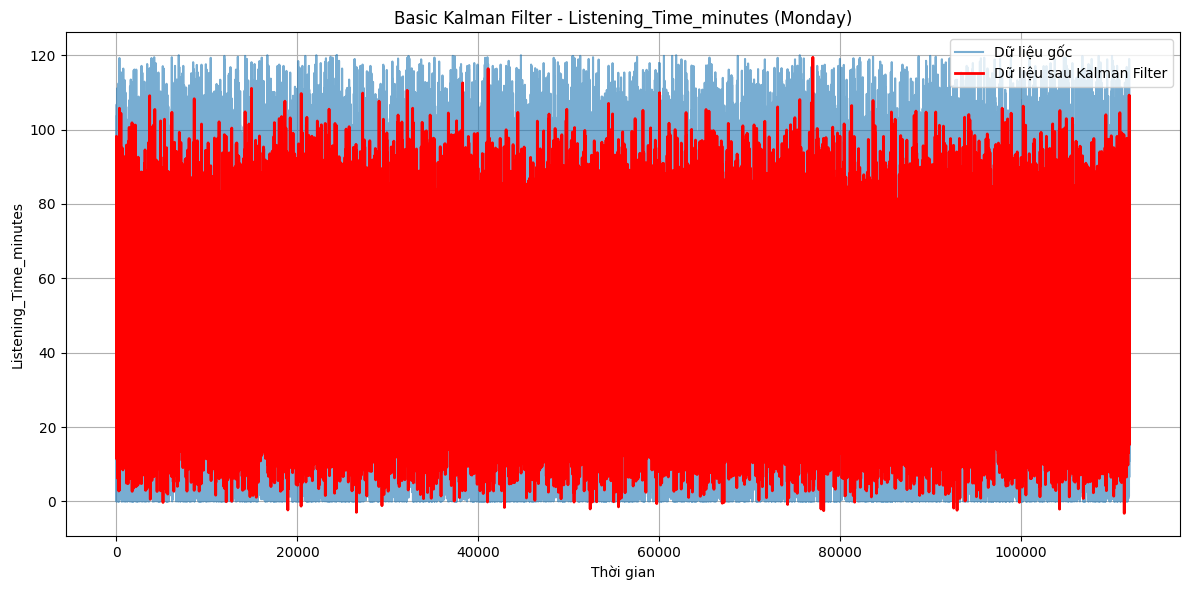

In [ ]:
from filterpy.kalman import KalmanFilter
data_col = 'Listening_Time_minutes'
data = df_monday[data_col].dropna().values

# Basic Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([data[0], 0.])  # [giá trị ban đầu, tốc độ]
kf.F = np.array([[1., 1.], [0., 1.]])  # ma trận chuyển đổi trạng thái
kf.H = np.array([[1., 0.]])           # ma trận đo
kf.P *= 1000.                         # hiệp phương sai ban đầu
kf.R = 10                             # nhiễu đo

# Lọc tuần tự
filtered = []
for z in data:
    kf.predict()
    kf.update(z)
    filtered.append(kf.x[0])

plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu gốc', alpha=0.6)
plt.plot(filtered, label='Dữ liệu sau Kalman Filter', color='red', linewidth=2)
plt.title('Basic Kalman Filter - Listening_Time_minutes (Monday)')
plt.xlabel('Thời gian')
plt.ylabel('Listening_Time_minutes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

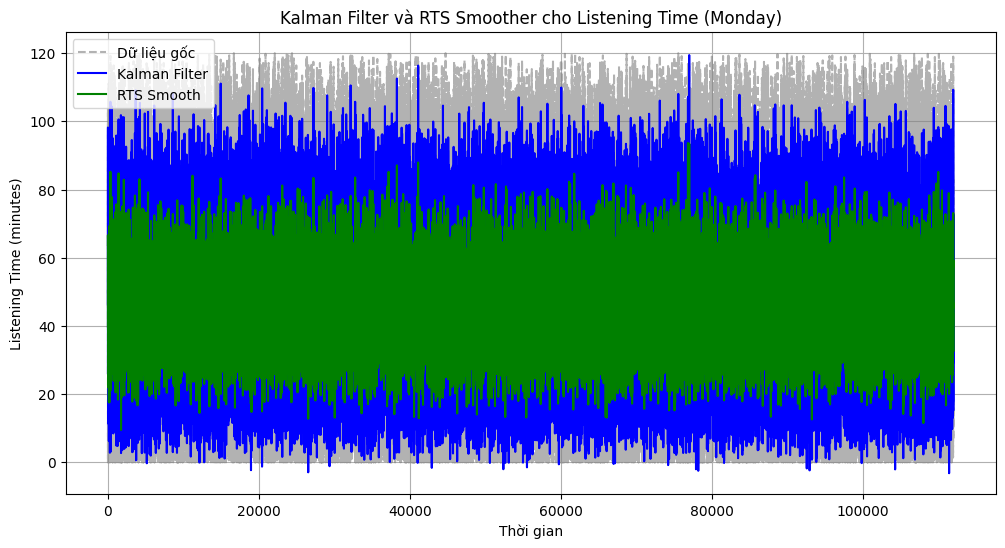

In [ ]:
from filterpy.kalman import KalmanFilter
data_col = 'Listening_Time_minutes'
data = df_monday[data_col].dropna().values

# Basic Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([data[0], 0.])  # [giá trị ban đầu, tốc độ]
kf.F = np.array([[1., 1.], [0., 1.]])  # ma trận chuyển đổi trạng thái
kf.H = np.array([[1., 0.]])           # ma trận đo
kf.P *= 1000.                         # hiệp phương sai ban đầu
kf.R = 10                             # nhiễu đo

# Lọc tuần tự và lưu trữ mu và cov
mu, cov = [], [] # Khởi tạo danh sách rỗng để lưu trữ mu và cov
for z in data:
    kf.predict()
    kf.update(z)
    mu.append(kf.x) # Lưu trữ giá trị trung bình trạng thái
    cov.append(kf.P) # Lưu trữ hiệp phương sai trạng thái


# Chuyển đổi danh sách thành mảng NumPy
mu = np.array(mu)
cov = np.array(cov)


# RTS Smoother
smoothed_mu, smoothed_cov, _, _ = kf.rts_smoother(mu, cov)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu gốc', color='gray', linestyle='--', alpha=0.6)
plt.plot(mu[:, 0], label='Kalman Filter', color='blue')
plt.plot(smoothed_mu[:, 0], label='RTS Smooth', color='green')
plt.title('Kalman Filter và RTS Smoother cho Listening Time (Monday)')
plt.xlabel('Thời gian')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)

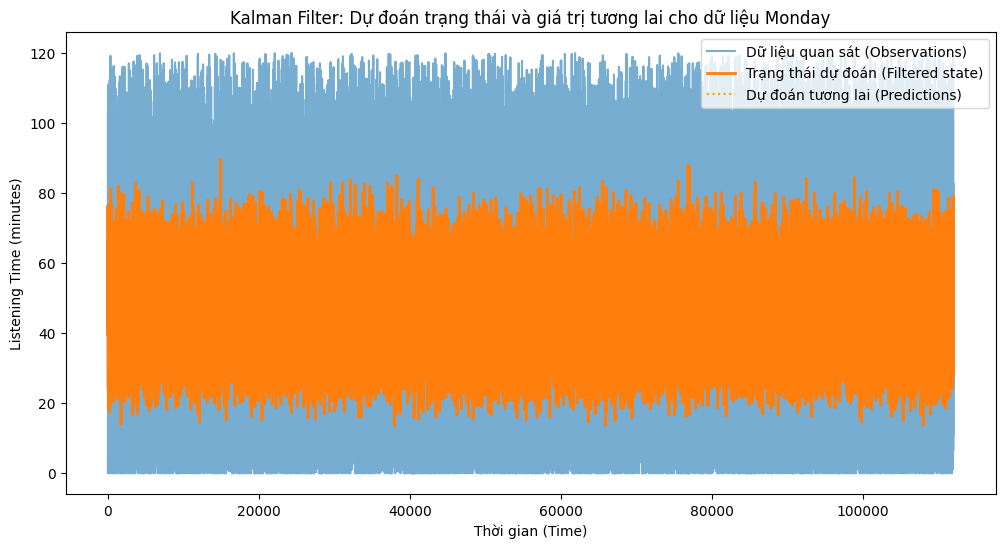

In [ ]:
# Kalman Filter với tham số cố định
class SimpleKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_covariance, measurement_covariance):
        self.state = initial_state  # Trạng thái ban đầu
        self.covariance = initial_covariance  # Hiệp phương sai ban đầu
        self.process_covariance = process_covariance  # Nhiễu hệ thống (Q)
        self.measurement_covariance = measurement_covariance  # Nhiễu đo (R)

    def predict(self):
        # Tiên đoán trạng thái tiếp theo
        self.state = self.state  # Trạng thái không thay đổi
        self.covariance = self.covariance + self.process_covariance  # Cập nhật hiệp phương sai dựa vào nhiễu

    def update(self, measurement):
        # Cập nhật trạng thái với phép đo mới (z_k = H * x_k + v_k)
        kalman_gain = self.covariance / (self.covariance + self.measurement_covariance)
        self.state = self.state + kalman_gain * (measurement - self.state)
        self.covariance = (1 - kalman_gain) * self.covariance

# Khởi tạo SimpleKalmanFilter với các tham số ban đầu
# Ví dụ:
initial_state = data[0]
initial_covariance = 100
process_covariance = 1
measurement_covariance = 10
kf = SimpleKalmanFilter(initial_state, initial_covariance, process_covariance, measurement_covariance) # Initialize kf as SimpleKalmanFilter

# Lọc dữ liệu quan sát
filtered_state = []

# Lọc qua tất cả các dữ liệu quan sát
for z in data:
    kf.predict()  # Tiên đoán giá trị tiếp theo
    kf.update(z)  # Cập nhật với giá trị thực tế
    filtered_state.append(kf.state) # Now you can access kf.state

# Dự đoán giá trị tương lai
future_steps = 10  # Dự đoán 10 bước tiếp theo
predictions = []

# Tiên đoán giá trị cho các bước tiếp theo mà không có dữ liệu quan sát
for _ in range(future_steps):
    kf.predict()  # Tiên đoán giá trị cho bước tiếp theo
    predictions.append(kf.state)

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu quan sát (Observations)', alpha=0.6)
plt.plot(filtered_state, label='Trạng thái dự đoán (Filtered state)', linewidth=2)
plt.plot(range(len(data), len(data) + future_steps), predictions, label='Dự đoán tương lai (Predictions)', linestyle='dotted', color='orange')
plt.legend()
plt.title("Kalman Filter: Dự đoán trạng thái và giá trị tương lai cho dữ liệu Monday")
plt.xlabel("Thời gian (Time)")
plt.ylabel("Listening Time (minutes)")
plt.show()